In [1]:
from sklearn.manifold import TSNE  # Import t-SNE dimensionality reduction algorithm
from sklearn.metrics import accuracy_score  # Import accuracy evaluation metric
from sklearn.decomposition import SparsePCA
from sklearn.neighbors import KNeighborsClassifier  # Import K-nearest neighbors classifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # Set the Chinese font for plotting to SimHei
plt.rcParams['axes.unicode_minus'] = False  # Resolve the issue of displaying negative signs as squares in plots
from PIL import Image
import numpy as np
import os  # Import operating system tools
import pandas as pd

data preprocessing

In [2]:
def image_to_vector(path):
    '''transform 2D image to one dimension array'''
    returnVec = np.zeros(784)
    img = Image.open(path)
    pixel = np.array(img) #2D array
    for i in range(28):
        for j in range(28):
            returnVec[i*28+j] = pixel[i][j] # transform 2d to 1d
    return returnVec

def load_data(dataset_path):
    '''read image data and label'''
    image_list = [] # store image vector
    label_list = [] # store label value

    labels_path_list = os.listdir(dataset_path) # get directory list under datasets path
    # labels_path_list.pop(0) # remove the first element

    for i in range(len(labels_path_list)): # list label folders
        image_label_path = dataset_path+'/'+labels_path_list[i] # label folders
        image_path_list = os.listdir(image_label_path) # list images
        for image_path in image_path_list:
            vector = image_to_vector(image_label_path+'/'+image_path)
            image_list.append(vector)
            label_list.append(int(labels_path_list[i]))

    image_list = np.array(image_list)
    label_list = np.array(label_list)
    print('dimension of image vector:',image_list.shape, 'dimension of label:', label_list.shape)
    return image_list, label_list

x_train, y_train = load_data(dataset_path='./data/train')
x_test, y_test = load_data(dataset_path='./data/test')

dimension of image vector: (60000, 784) dimension of label: (60000,)
dimension of image vector: (10000, 784) dimension of label: (10000,)


In [3]:
# standardize data
std = StandardScaler()
x_train_std = std.fit_transform(x_train)
x_test_std = std.fit_transform(x_test)

In [4]:
# reduce dimension of image
from sklearn.decomposition import PCA

# we should ensure data can explain 90% original data after PCA
pca = PCA()
pca.fit(x_train_std)

# Calculate cumulative sum of explained variances
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components for more than 90% variance
num_components = np.where(cumulative_variance > 0.9)[0][0] + 1  # Adding 1 as indexing starts from 0

num_components

236

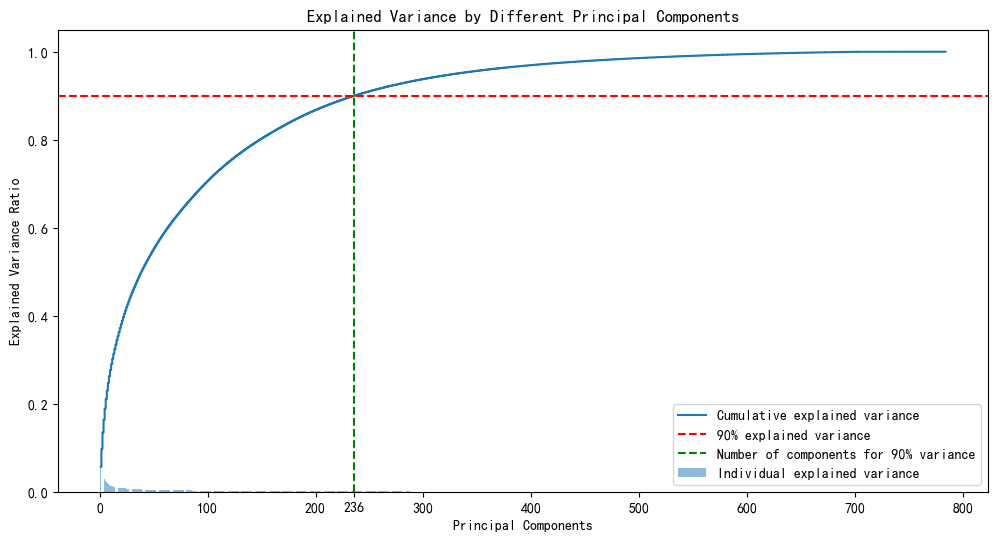

In [5]:
plt.figure(figsize=(12,6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% explained variance')
plt.axvline(x=num_components, color='g', linestyle='--', label='Number of components for 90% variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.xticks(ticks=[0,100,200,num_components,300,400,500,600,700,800])
plt.legend(loc='best')
plt.title('Explained Variance by Different Principal Components')
plt.show()

In [4]:
from sklearn.decomposition import PCA
pca_optimal = PCA(n_components=236)

x_train_pca = pca_optimal.fit_transform(x_train_std)
x_test_pca = pca_optimal.transform(x_test_std)

print(f"train data dimension:{x_train_pca.shape}. test data dimension:{x_test_pca.shape}")

train data dimension:(60000, 236). test data dimension:(10000, 236)


train k-NN to recognize handwritten number.  

In [9]:
# choose optimal parameters
knn_parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10],
              'weights':['uniform','distance'],
              'p':[1,2] #p=1, Manhattan distance; p=2, the Euclidean distance
              }

knn = KNeighborsClassifier()
# uses cross-validated grid search to find the best combination of hyperparameters.
knn_grid_search = GridSearchCV(knn, knn_parameters, scoring='accuracy', cv=5, verbose=100, n_jobs=1)
knn_grid_search.fit(x_train_pca, y_train)
knn_label = knn_grid_search.predict(x_test_pca)
print(knn_grid_search.best_score_, knn_grid_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 1/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.938 total time=   8.3s
[CV 2/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 2/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.939 total time=   8.5s
[CV 3/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 3/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.940 total time=   8.7s
[CV 4/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 4/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.936 total time=   8.6s
[CV 5/5; 1/40] START n_neighbors=1, p=1, weights=uniform........................
[CV 5/5; 1/40] END n_neighbors=1, p=1, weights=uniform;, score=0.945 total time=   8.6s
[CV 1/5; 2/40] START n_neighbors=1, p=1, weights=distance.......................
[CV 1/5; 2/4

In [5]:
# use optimal parameters to train knn
knn = KNeighborsClassifier(n_neighbors=4, weights='distance', p=2)
knn.fit(x_train_pca, y_train)
knn_predict_label = knn.predict(x_test_pca)
acc = accuracy_score(y_test, knn_predict_label)
print(acc)

0.9551


In [7]:
# report classification results
n_class = 10
from sklearn.metrics import classification_report
label = [i for i in range(n_class)]
knn_report = classification_report(y_test, knn_predict_label, labels=label, output_dict=True)
knn_df = pd.DataFrame(knn_report).transpose()
knn_df.columns = ['knn_precision','knn_recall', 'knn_f1-score', 'knn_support']
print(knn_df)

              knn_precision  knn_recall  knn_f1-score  knn_support
0                  0.965966    0.984694      0.975240     980.0000
1                  0.974138    0.995595      0.984749    1135.0000
2                  0.962672    0.949612      0.956098    1032.0000
3                  0.941406    0.954455      0.947886    1010.0000
4                  0.963880    0.951120      0.957458     982.0000
5                  0.939933    0.947309      0.943607     892.0000
6                  0.964912    0.975992      0.970420     958.0000
7                  0.939747    0.940661      0.940204    1028.0000
8                  0.957401    0.922998      0.939885     974.0000
9                  0.937626    0.923687      0.930604    1009.0000
accuracy           0.955100    0.955100      0.955100       0.9551
macro avg          0.954768    0.954612      0.954615   10000.0000
weighted avg       0.955056    0.955100      0.955002   10000.0000


train SVM to recognize handwritten number.  

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV #hyperparameter tuning

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# choose optimal parameters
svm_parameters = {
    'kernel': ['rbf', 'poly'],
    'gamma': [1e-3, 1e-4, 1e-5],
    'C': [10, 100]
}

# use random search to accelerate
svc = SVC()
svc_grid_search = RandomizedSearchCV(svc, param_distributions=svm_parameters, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, verbose=100)
svc_grid_search.fit(x_train_std, y_train)
svc_label = svc_grid_search.predict(x_test_std)
print(svc_grid_search.best_score_, svc_grid_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [8]:
svc = SVC(kernel='poly', gamma=0.001, C=100)
svc.fit(x_train_pca, y_train)
svc_predict_label = svc.predict(x_test_pca)
svc_acc = accuracy_score(y_test, svc_predict_label)
print(svc_acc)

0.9772


In [9]:
# report classification results
from sklearn.metrics import classification_report
label = [i for i in range(n_class)]
svm_report = classification_report(y_test, svc_predict_label, labels=label, output_dict=True)
svm_df = pd.DataFrame(svm_report).transpose()
svm_df.columns = ['svm_precision','svm_recall', 'svm_f1-score', 'svm_support']
print(svm_df)

              svm_precision  svm_recall  svm_f1-score  svm_support
0                  0.985787    0.990816      0.988295     980.0000
1                  0.990351    0.994714      0.992527    1135.0000
2                  0.974806    0.974806      0.974806    1032.0000
3                  0.976378    0.982178      0.979269    1010.0000
4                  0.970737    0.979633      0.975165     982.0000
5                  0.973003    0.969731      0.971364     892.0000
6                  0.978992    0.972860      0.975916     958.0000
7                  0.984190    0.968872      0.976471    1028.0000
8                  0.962513    0.975359      0.968893     974.0000
9                  0.972892    0.960357      0.966584    1009.0000
accuracy           0.977200    0.977200      0.977200       0.9772
macro avg          0.976965    0.976933      0.976929   10000.0000
weighted avg       0.977220    0.977200      0.977190   10000.0000


              knn_precision  knn_recall  knn_f1-score  knn_support  \
0                  0.965966    0.984694      0.975240     980.0000   
1                  0.974138    0.995595      0.984749    1135.0000   
2                  0.962672    0.949612      0.956098    1032.0000   
3                  0.941406    0.954455      0.947886    1010.0000   
4                  0.963880    0.951120      0.957458     982.0000   
5                  0.939933    0.947309      0.943607     892.0000   
6                  0.964912    0.975992      0.970420     958.0000   
7                  0.939747    0.940661      0.940204    1028.0000   
8                  0.957401    0.922998      0.939885     974.0000   
9                  0.937626    0.923687      0.930604    1009.0000   
accuracy           0.955100    0.955100      0.955100       0.9551   
macro avg          0.954768    0.954612      0.954615   10000.0000   
weighted avg       0.955056    0.955100      0.955002   10000.0000   

              svm_p

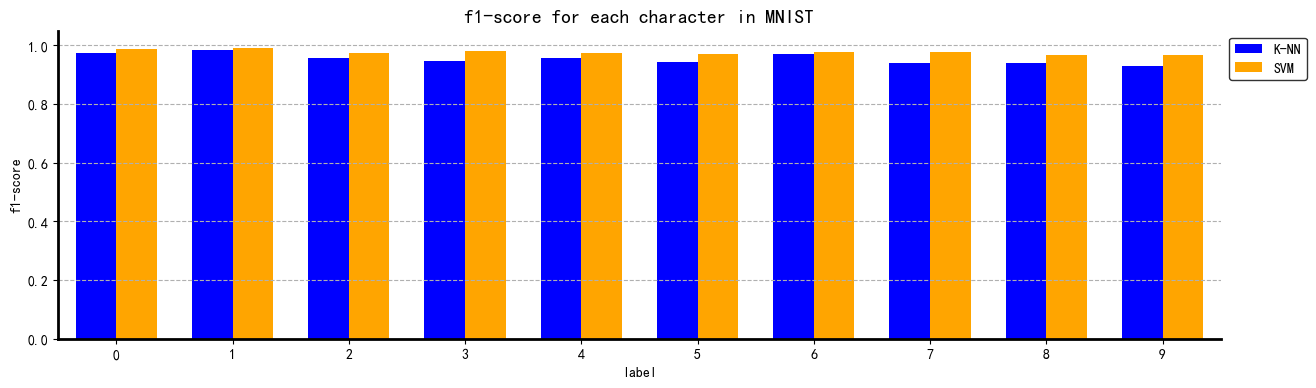

In [14]:
# store report to excel
df = pd.concat([knn_df, svm_df], axis=1)
print(df)
df.to_excel('./MNIST_report.xlsx')

# draw bar chart for KNN and SVM f1-score
fig, ax = plt.subplots(figsize=(15, 4))

bar_width = 0.35
index = knn_df[:-3].index.astype(int)  # Convert index to integers

knn_bars = ax.bar(index - bar_width / 2, knn_df[:-3]['knn_f1-score'], bar_width, label='K-NN', color='blue')
svm_bars = ax.bar(index + bar_width / 2, svm_df[:-3]['svm_f1-score'], bar_width, label='SVM', color='orange')

ax.grid(axis='y', ls='--')
ax.legend(fontsize=10, edgecolor='black', loc='upper right', bbox_to_anchor=(1.08, 1))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(0, 1.05)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.title('f1-score for each character in MNIST', fontweight='bold', fontsize=14)
plt.xlabel('label')
plt.ylabel('f1-score')

# Adding labels for each bar on the x-axis
ax.set_xticks(index)
ax.set_xticklabels(index)

plt.show()

Normality test for knn and svm accuracy

In [15]:
from scipy import stats
report_data = pd.read_excel('MNIST_report.xlsx')
report_data.head()
KNN_f1 = report_data['knn_f1-score'].to_numpy()
SVM_f1 = report_data['svm_f1-score'].to_numpy()

# Perform the Shapiro-Wilk test on the skewed dataset
knn_statistic, knn_p_value = stats.shapiro(KNN_f1)
svm_statistic, svm_p_value = stats.shapiro(SVM_f1)

# Set the significance level (alpha)
alpha = 0.1

# Interpret the knn results
if knn_p_value > alpha:
    print("knn accuracy looks normally distributed (fail to reject H0)")
else:
    print("knn accuracy does not look normally distributed (reject H0)")

# Print the test statistic and p-value
print(f"Shapiro-Wilk Statistic: {knn_statistic:.4f}")
print(f"P-Value: {knn_p_value:.4f}")

# Interpret the svm results
if svm_p_value > alpha:
    print("svm accuracy looks normally distributed (fail to reject H0)")
else:
    print("svm accuracy does not look normally distributed (reject H0)")

# Print the test statistic and p-value
print(f"Shapiro-Wilk Statistic: {svm_statistic:.4f}")
print(f"P-Value: {svm_p_value:.4f}")

knn accuracy looks normally distributed (fail to reject H0)
Shapiro-Wilk Statistic: 0.9547
P-Value: 0.6715
svm accuracy looks normally distributed (fail to reject H0)
Shapiro-Wilk Statistic: 0.8931
P-Value: 0.1076


Two-Sample Paired t-test for K-NN and SVM

In [17]:
import numpy as np
from scipy import stats

# Perform two-sample paired t-test
t_statistic, p_value = stats.ttest_rel(KNN_f1, SVM_f1)

# Display the results
print("Two-Sample Paired t-Test Results:")
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Check for statistical significance at a 0.05 significance level
alpha = 0.05
if p_value < alpha:
    print("Result is statistically significant: Reject the null hypothesis")
else:
    print("Result is not statistically significant: Fail to reject the null hypothesis")

Two-Sample Paired t-Test Results:
T-Statistic: -8.200765101498625
P-Value: 2.914609643696508e-06
Result is statistically significant: Reject the null hypothesis


KNN and SVM show significant difference on MNIST. Draw ROC curve to compare their prerformances.

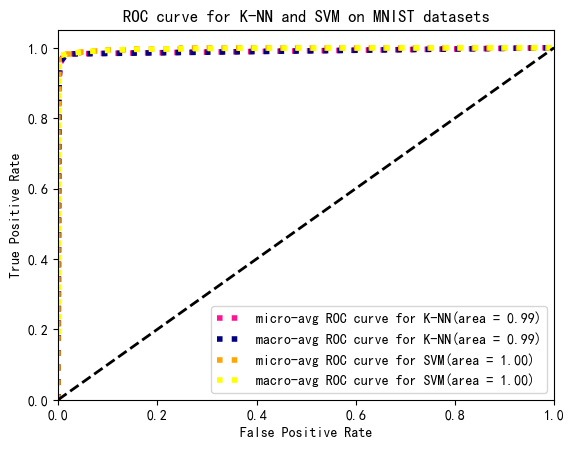

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=list(range(n_class)))

# knn ROC
knn_y_score = knn.predict_proba(x_test_pca)

# compute each character ROC curve and AUC value
knn_fpr = dict()
knn_tpr = dict()
knn_roc_auc = dict()
for i in range(n_class):
    knn_fpr[i], knn_tpr[i], _ = roc_curve(y_test_bin[:, i], knn_y_score[:, i])
    knn_roc_auc[i] = auc(knn_fpr[i], knn_tpr[i])

# Compute micro-average ROC curve and ROC area
knn_fpr["micro"], knn_tpr["micro"], _ = roc_curve(y_test_bin.ravel(), knn_y_score.ravel())
knn_roc_auc["micro"] = auc(knn_fpr["micro"], knn_tpr["micro"])

# compute marco-average ROC curve and ROC area
all_knn_fpr = np.unique(np.concatenate([knn_fpr[i] for i in range(n_class)])) # First aggregate all false positive rates
mean_knn_tpr = np.zeros_like(all_knn_fpr) # Then interpolate all ROC curves at this points

for i in range(n_class):
    mean_knn_tpr += np.interp(all_knn_fpr, knn_fpr[i], knn_tpr[i])


mean_knn_tpr /= n_class # Finally average it and compute AUC
knn_fpr["macro"] = all_knn_fpr
knn_tpr["macro"] = mean_knn_tpr
knn_roc_auc["macro"] = auc(knn_fpr["macro"], knn_tpr["macro"])

# svm ROC
svm_y_score = svc.decision_function(x_test_pca)


# compute each character ROC curve and AUC value
svm_fpr = dict()
svm_tpr = dict()
svm_roc_auc = dict()
for i in range(n_class):
    svm_fpr[i], svm_tpr[i], _ = roc_curve(y_test_bin[:, i], svm_y_score[:, i])
    svm_roc_auc[i] = auc(svm_fpr[i], svm_tpr[i])

# Compute micro-average ROC curve and ROC area
svm_fpr["micro"], svm_tpr["micro"], _ = roc_curve(y_test_bin.ravel(), svm_y_score.ravel())
svm_roc_auc["micro"] = auc(svm_fpr["micro"], svm_tpr["micro"])

# compute marco-average ROC curve and ROC area
all_svm_fpr = np.unique(np.concatenate([svm_fpr[i] for i in range(n_class)])) # First aggregate all false positive rates
mean_svm_tpr = np.zeros_like(all_svm_fpr) # Then interpolate all ROC curves at this points

for i in range(n_class):
    mean_svm_tpr += np.interp(all_svm_fpr, svm_fpr[i], svm_tpr[i])


mean_svm_tpr /= n_class # Finally average it and compute AUC
svm_fpr["macro"] = all_svm_fpr
svm_tpr["macro"] = mean_svm_tpr
svm_roc_auc["macro"] = auc(svm_fpr["macro"], svm_tpr["macro"])

# plot all ROC curves
lw=2
plt.figure()
plt.plot(knn_fpr["micro"], knn_tpr["micro"],
         label='micro-avg ROC curve for K-NN(area = {0:0.2f})'
               ''.format(knn_roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(knn_fpr["macro"], knn_tpr["macro"],
         label='macro-avg ROC curve for K-NN(area = {0:0.2f})'
               ''.format(knn_roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(svm_fpr["micro"], svm_tpr["micro"],
         label='micro-avg ROC curve for SVM(area = {0:0.2f})'
               ''.format(svm_roc_auc["micro"]),
         color='orange', linestyle=':', linewidth=4)

plt.plot(svm_fpr["macro"], svm_tpr["macro"],
         label='macro-avg ROC curve for SVM(area = {0:0.2f})'
               ''.format(svm_roc_auc["macro"]),
         color='yellow', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for K-NN and SVM on MNIST datasets')
plt.legend(loc="lower right")
plt.show()